<a href="https://colab.research.google.com/github/sagarchaulagai/lab2-ai/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Corrected the import name from LabelEncode to LabelEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
# --- Utility Functions ---
def euclidean_distance(point1, point2):
    """Calculates the Euclidean distance between two points."""
    return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))


In [3]:
def generate_k(n_samples):
    """
    Generates a suitable odd value for k based on the size of the dataset.
    This k is used for the initial single prediction.
    """
    k = int(np.sqrt(n_samples))
    if k % 2 == 0:
        k += 1
    k = max(1, k)  # Ensure k is at least 1
    return k

In [4]:
def knn_predict(training_data, training_labels, test_point, k):
    """
    Predicts the label of a test point using the k-NN algorithm.
    This is a custom implementation, not scikit-learn's.
    """
    distances = []
    for i in range(len(training_data)):
        dist = euclidean_distance(test_point, training_data[i])
        distances.append((dist, training_labels[i]))
    distances.sort(key=lambda x: x[0])  # Sort by distance
    k_nearest_labels = [label for _, label in distances[:k]]  # Get labels of k nearest neighbors
    return Counter(k_nearest_labels).most_common(1)[0][0] # Return the most common label


In [5]:
def suggest_n_splits(n_samples, labels):
    """
    Suggests a suitable n_splits for StratifiedKFold based on dataset size
    and class distribution.
    """
    unique_labels, counts = np.unique(labels, return_counts=True)
    min_samples_per_class = min(counts)

    # Custom logic based on your specified values
    if n_samples >= 40:
        return min(6, min_samples_per_class)
    elif n_samples >= 30:
        return min(5, min_samples_per_class)
    elif n_samples >= 25:
        return min(5, min_samples_per_class)
    elif n_samples >= 10:
        return min(4, min_samples_per_class)
    else:  # Fewer than 10 samples
        return min(3, n_samples - 1, min_samples_per_class)


In [6]:
# --- Data Definition ---
#40 samples
training_data = [
    [19, 18000], [20, 17000], [21, 16000], [22, 15500], [23, 16500],
    [24, 17500], [25, 18500], [26, 19500], [27, 20000], [28, 20500],
    [29, 21000], [30, 21500], [31, 22000], [32, 22500], [33, 23000],
    [34, 23500], [35, 24000], [36, 24500], [37, 25000], [38, 25500],
    [39, 26000], [40, 26500], [41, 27000], [42, 27500], [43, 28000],
    [44, 28500], [45, 29000], [20, 15000], [21, 15800], [22, 16800],
    [23, 17800], [24, 18800], [25, 19800], [26, 20800], [27, 21800],
    [28, 22800], [29, 23800], [30, 24800], [31, 25800], [32, 26800],
    [25, 25500], [19, 17500], [32, 27000], [23, 19000], [21, 16500],
    [27, 23000], [40, 29000], [29, 24000], [34, 28000], [22, 15500],
    [28, 26500], [24, 25000], [26, 21500], [30, 30000], [31, 23500],
    [20, 18000], [35, 27500], [33, 28500], [39, 29500], [36, 26000],
    [41, 18500], [38, 21000], [37, 22000], [19, 16000], [42, 24500],
    [44, 25500], [43, 20500], [45, 20000], [30, 23000], [29, 22500],
    [21, 17000]

]
training_labels = [
    'A', 'A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C',
    'A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'A',
    'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B',
    'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C',
    'B', 'A', 'C', 'A', 'A', 'B', 'C', 'B', 'C', 'A',
    'C', 'B', 'A', 'C', 'B', 'A', 'B', 'C', 'C', 'C',
    'A', 'A', 'B', 'A', 'B', 'C', 'A', 'A', 'B', 'B',
    'A'
]

test_point = [24, 25000]

In [7]:
# Convert to NumPy arrays for scikit-learn compatibility
X_train = np.array(training_data)
y_train = np.array(training_labels)

In [8]:
# --- Initial Prediction with default k ---
initial_k = generate_k(len(X_train))
print(f"Number of training samples: {len(X_train)}")

predicted_label = knn_predict(training_data, training_labels, test_point, initial_k)
print(f"Prediction for test point {test_point} with k={initial_k}: {predicted_label}")


Number of training samples: 71
Prediction for test point [24, 25000] with k=9: B


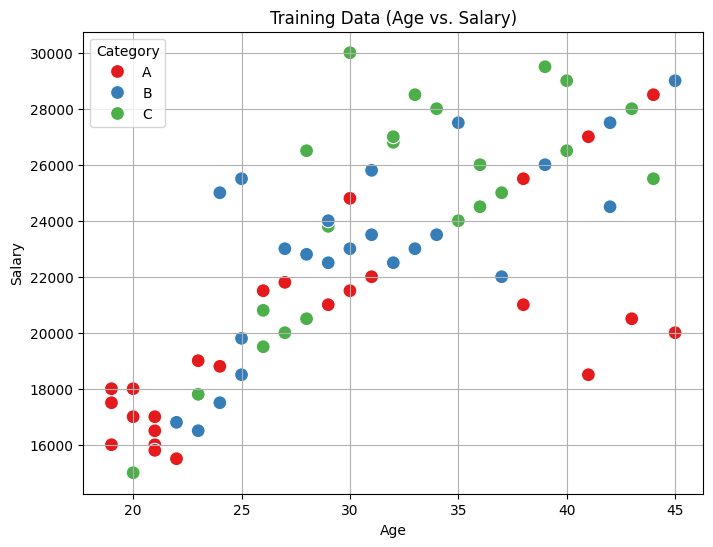

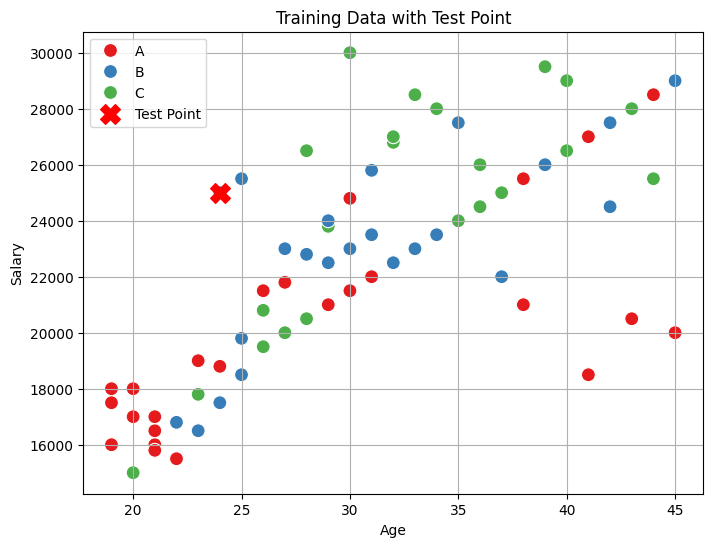

In [9]:
# --- Data Visualization ---
df_training = pd.DataFrame(X_train, columns=["Age", "Salary"])
df_training['Category'] = y_train

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_training, x="Age", y="Salary", hue="Category", palette="Set1", s=100)
plt.title("Training Data (Age vs. Salary)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_training, x="Age", y="Salary", hue="Category", palette="Set1", s=100)
plt.scatter(test_point[0], test_point[1], color='red', marker='X', s=200, label='Test Point')
plt.title("Training Data with Test Point")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
#Cross-Validation for Optimal k
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

In [11]:
#Range of K values
k_range = [i for i in range(1, 6) if i % 2 != 0]

In [12]:

cv_scores = []
n_folds_cv = 3 # Fixed number of folds to resolve ValueError
print(f"Performing {n_folds_cv}-fold cross-validation for k-selection.")
for k_val in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k_val)
    scores = cross_val_score(
        knn_model,
        X_train,
        y_encoded,
        cv=StratifiedKFold(n_splits=n_folds_cv, shuffle=True, random_state=42),
        scoring='accuracy'
    )
    cv_scores.append(scores.mean())

Performing 3-fold cross-validation for k-selection.


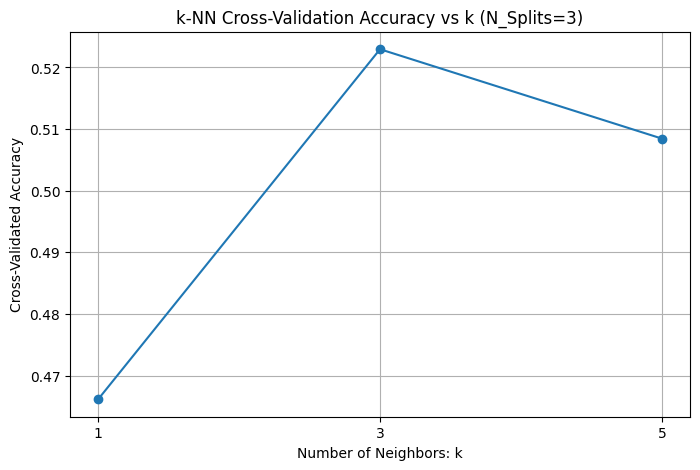

In [13]:
# Plot accuracy vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_range, cv_scores, marker='o')
plt.title(f"k-NN Cross-Validation Accuracy vs k (N_Splits={n_folds_cv})")
plt.xlabel("Number of Neighbors: k")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)
plt.xticks(k_range) # Ensure x-ticks are for tested k values
plt.show()


In [14]:
# Best k
best_k = k_range[np.argmax(cv_scores)]
print(f"Best k from cross-validation: {best_k}")

Best k from cross-validation: 3
